In [1]:
import os
from glob import glob
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt     # for plotting
import cv2 
import soundfile as sf
import timeit

import librosa
import pandas as pd
from IPython.display import Audio
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from collections import Counter

from tensorflow.keras.layers import LSTM, Dense

In [2]:

from numpy.random import seed
seed(1)
tf.random.set_seed(2)

Global Variables

In [3]:
# Data path:
data_path = '../data/'
speakers_path = '../SPEAKERS.TXT'

sample_rate = 32000
off_set = 0
duration = 5.0

# If you decide to use batch sizes:
batch_size = 10000

sample_size = (round((sample_rate*duration)), 1)

#Mel features
hop_length = 512 #the default spacing between frames, try 512?
n_fft = 1024 #number of samples
n_mels = 64



Helper Functions

In [4]:
def extract_id_sex():
    id_sex_array = []
    with open(speakers_path, 'r') as file:
        # Skip the header line
        next(file)
        for line in file:
            # Split the line into columns
            columns = line.split('|')
            # Extract the ID and SEX
            id_value = columns[0].strip()
            sex_value = columns[1].strip()
            # Append ID and SEX to the array
            id_sex_array.append((id_value, sex_value))
    return id_sex_array

# Lets store the speaker gender, it'll only be used once.
speaker_gender = extract_id_sex()

def load_directory():
    # Find all samples in the directory
    files = glob(os.path.join(data_path, '*.flac'))
    # The audio data
    x = []
    # The gender and speaker ID
    y = []

    # Create a dictionary for speaker genders
    speaker_gender_dict = {speaker[0]: speaker[1] for speaker in speaker_gender}

    counter_f = 0
    counter_m = 0
    speakers = []

    if batch_size > len(files):
        error_msg = f'Requested a batch size greater than the number of samples available ({len(files)})'
        raise ValueError(error_msg)

    for file in files:
        if (len(x) == batch_size):
            break
        
        # Collect the speaker IDs, because we are classifying on gender the speakerID does not 
        # matter as a label, but it does help us ensure we have a diverse representation of 
        # speakers for each gender, so we will only take 1 sample per speaker for each gender.
        fileName = file.split('\\')[1]
        speakerId = fileName.split('-')[0]

        # Due to limited number of samples per speaker limit the below code to 14500
        if batch_size < 14500:
            # extract an even number of samples from each speaker ensuring we get a diverse
            # range of speakers 
            num_samples_per_speaker = round(batch_size / 250)
            speaker_count = Counter(speakers)
            if (speaker_count[speakerId] >= num_samples_per_speaker):
                continue
        
        # Use dictionary for faster search performance.
        gender = speaker_gender_dict.get(speakerId)

        if (gender == 'F' and (counter_f < batch_size/2)):
            data, _ = librosa.load(file, sr=sample_rate, offset=off_set, duration=duration)
            
            if (data.size < (sample_rate*duration)):
                continue
            x.append(data)
            y.append((gender, speakerId))
            speakers.append(speakerId)
            counter_f = counter_f + 1

        elif (gender == 'M' and (counter_m < batch_size/2)):
            data, _ = librosa.load(file, sr=sample_rate, offset=off_set, duration=duration)
            if (data.size < (sample_rate*duration)):
                continue
            x.append(data)
            y.append((gender, speakerId))
            speakers.append(speakerId)
            counter_m = counter_m + 1
    x = [get_mels(x_data, sample_rate, hop_length, n_fft, n_mels).T  for x_data in x]
    return np.array(x), np.array(y)

In [5]:
#Helper Functions

def get_mels(x, sample_rate, hop_length=512, n_fft=1024, n_mels=64):
    
    S = librosa.feature.melspectrogram(y =x, sr = sample_rate, hop_length=hop_length,n_fft = n_fft, n_mels=n_mels)
    S_db_mel = librosa.power_to_db(S, ref=np.max)
    return S_db_mel


# Convert iterable into batches of size n
#   iterable: original list of data to be batched
#   n: batch size 

#   yields:   a list of batches with each batch of size n
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

# Get y label and a unique ID for each file and load the file into a tuple
#   file: directory to the file

#   returns:   a tuple containing the audio file, speaker ID and a unique ID for the file name
def get_metadata(file):
    basename = os.path.basename(file)
    data, samp_rate = librosa.load(file, sr=sample_rate)
    speakerId = basename.split('-')[0]
    uniqueId = basename.split('.')[0]
    return (data, uniqueId), speakerId


In [6]:
#extract_sequences(X_train, 20, 20, 5, 128)

Load Data

In [7]:
x_data, y = load_directory()
# Information on the extracted audio data:
print(f'x data, first sample: {x_data[0]}')
print(f'shape x data: {x_data.shape}')

y_data = np.array([row[0] for row in y])
speakerIds = [row[1] for row in y]
print(f'shape y data: {y_data.shape}')

m_rows = y[y[:, 0] == 'M']
f_rows = y[y[:, 0] == 'F']
print()
print(f'Male Speakers: {len(np.unique(m_rows[:, 1]))}')
print(f'Female Speakers: {len(np.unique(f_rows[:, 1]))}')

from sklearn.preprocessing import LabelEncoder



x data, first sample: [[-27.368961 -29.47931  -36.750004 ... -75.74742  -75.96059  -76.09476 ]
 [-22.879776 -30.233055 -49.52315  ... -80.       -80.       -80.      ]
 [-21.997183 -28.55328  -47.38311  ... -80.       -80.       -80.      ]
 ...
 [-26.280758 -35.079685 -44.866646 ... -80.       -80.       -80.      ]
 [-17.730782 -24.628962 -51.294506 ... -80.       -80.       -80.      ]
 [-16.015625 -21.281998 -37.17293  ... -80.       -80.       -80.      ]]
shape x data: (10000, 313, 64)
shape y data: (10000,)

Male Speakers: 126
Female Speakers: 125


In [8]:
# X = np.array((X-np.min(X))/(np.max(X)-np.min(X)))
# X = X/np.std(X)
# y = np.array(y)

In [9]:
x_train, x_remain, y_train, y_remain = train_test_split(x_data, y_data, 
                                                        test_size=0.6, 
                                                        random_state=42, 
                                                        shuffle=True,
                                                        stratify=y_data)





x_val, x_test, y_val, y_test = train_test_split(x_remain, y_remain, 
                                                test_size=0.5, 
                                                random_state=42, 
                                                shuffle=True,
                                                stratify=y_remain)


In [10]:
# Convert 'M' (1) and 'F' (0) to numbers. 
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)
print(y_train[0])
print(y_train_encoded[0])
print(y_train[90])
print(y_train_encoded[90])

M
1
M
1


In [11]:
input_shape=(313, n_mels)
model = keras.Sequential()
model.add(LSTM(70,input_shape=input_shape, name='LSTM_1'))
#model.add(Dense(64, activation='relu'))
#model.add(layers.Dropout(0.2))
#model.add(Dense(32, activation='relu'))
#model.add(layers.Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_1 (LSTM)               (None, 70)                37800     
                                                                 
 dense (Dense)               (None, 16)                1136      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 38,953
Trainable params: 38,953
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(optimizer='adam',loss='BinaryCrossentropy',metrics=['acc'])

In [13]:
y_train

array(['M', 'F', 'M', ..., 'F', 'M', 'F'], dtype='<U1')

In [14]:
import time
start = time.time()
history = model.fit(x_train, y_train_encoded, epochs=100, batch_size=100, validation_data=(x_val, y_val_encoded), shuffle=False, verbose=True)
end = time.time()
model_training = end - start

Epoch 1/100
40/40 [==============================] - 23s 480ms/step - loss: 0.6461 - acc: 0.6665 - val_loss: 0.5814 - val_acc: 0.8133
Epoch 2/100
40/40 [==============================] - 18s 453ms/step - loss: 0.5559 - acc: 0.8282 - val_loss: 0.5223 - val_acc: 0.8507
Epoch 3/100
40/40 [==============================] - 18s 460ms/step - loss: 0.4570 - acc: 0.8630 - val_loss: 0.3928 - val_acc: 0.8733
Epoch 4/100
40/40 [==============================] - 19s 466ms/step - loss: 0.3814 - acc: 0.8670 - val_loss: 0.3235 - val_acc: 0.8897
Epoch 5/100
40/40 [==============================] - 19s 475ms/step - loss: 0.3564 - acc: 0.8765 - val_loss: 0.3826 - val_acc: 0.8787
Epoch 6/100
40/40 [==============================] - 19s 488ms/step - loss: 0.3267 - acc: 0.8817 - val_loss: 0.3296 - val_acc: 0.8777
Epoch 7/100
40/40 [==============================] - 19s 481ms/step - loss: 0.3022 - acc: 0.8882 - val_loss: 0.3255 - val_acc: 0.8997
Epoch 8/100
40/40 [==============================] - 23s 585ms

In [15]:
model_training

1960.4482729434967

In [16]:
101/60

1.6833333333333333

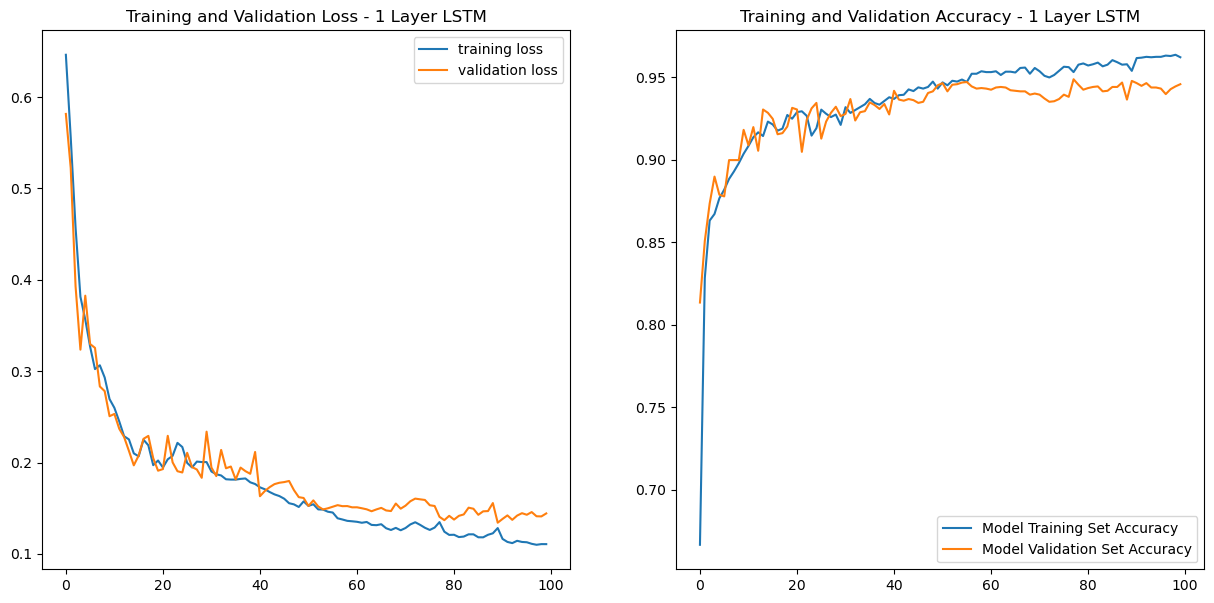

In [17]:
fig = plt.figure(figsize=[15, 7])
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['loss'], label='training loss')
ax.plot(history.history['val_loss'], label='validation loss')
ax.set_title('Training and Validation Loss - 1 Layer LSTM')
ax.legend()
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['acc'], label='Model Training Set Accuracy')
ax.plot(history.history['val_acc'], label='Model Validation Set Accuracy')
ax.set_title('Training and Validation Accuracy - 1 Layer LSTM')
ax.legend()
plt.savefig('../out/LSTM_model_loss_1_layer.png')

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score

pred_lab = model.predict(x_train);
train_indexes = np.round(pred_lab)

pred_lab = model.predict(x_val);
val_indexes = np.round(pred_lab)

start = time.time()
pred_lab = model.predict(x_test);
test_indexes = np.round(pred_lab)

f1_train = f1_score(y_train_encoded, train_indexes)
f1_val = f1_score(y_val_encoded, val_indexes)
f1_test = f1_score(y_test_encoded, test_indexes)


acc_train = accuracy_score(y_train_encoded, train_indexes)
acc_val = accuracy_score(y_val_encoded, val_indexes)
acc_test = accuracy_score(y_test_encoded, test_indexes)

end = time.time()
model_inference = end - start

In [19]:
acc_test

0.9486666666666667

In [20]:
model_inference

4.60630202293396

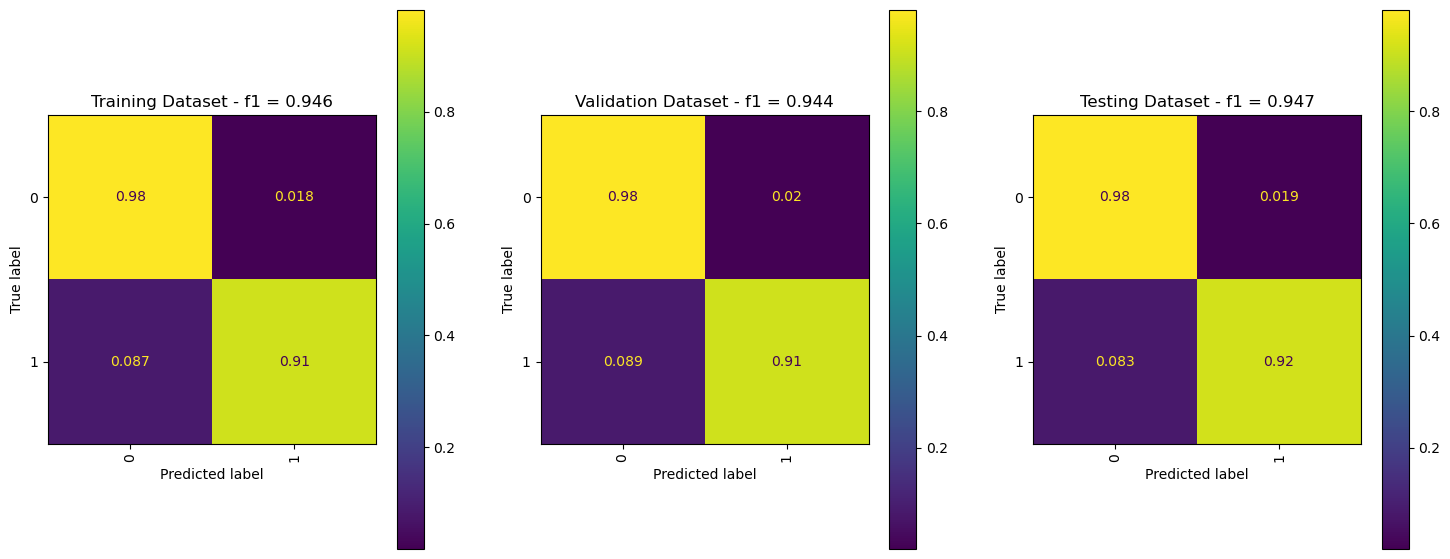

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
fig = plt.figure(figsize=[18, 7])


ax = fig.add_subplot(1, 3, 1)
ax.set_title(f"Training Dataset - f1 = {round(f1_train, 3)}")
cm = confusion_matrix(y_train_encoded, train_indexes, normalize='true')
c = ConfusionMatrixDisplay(cm)
c.plot(ax = ax, xticks_rotation = 'vertical')

ax = fig.add_subplot(1, 3, 2)
ax.set_title(f"Validation Dataset - f1 = {round(f1_val, 3)}")
cm = confusion_matrix(y_val_encoded, val_indexes, normalize='true')
c = ConfusionMatrixDisplay(cm)
c.plot(ax = ax, xticks_rotation = 'vertical')

ax = fig.add_subplot(1, 3, 3)
ax.set_title(f"Testing Dataset - f1 = {round(f1_test,3)}")
cm = confusion_matrix(y_test_encoded, test_indexes, normalize='true')
c = ConfusionMatrixDisplay(cm)
c.plot(ax = ax,  xticks_rotation = 'vertical')

plt.savefig('../out/LSTM_1_layer_Confusion_Matrix.jpg')

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1500
           1       0.98      0.92      0.95      1500

    accuracy                           0.95      3000
   macro avg       0.95      0.95      0.95      3000
weighted avg       0.95      0.95      0.95      3000



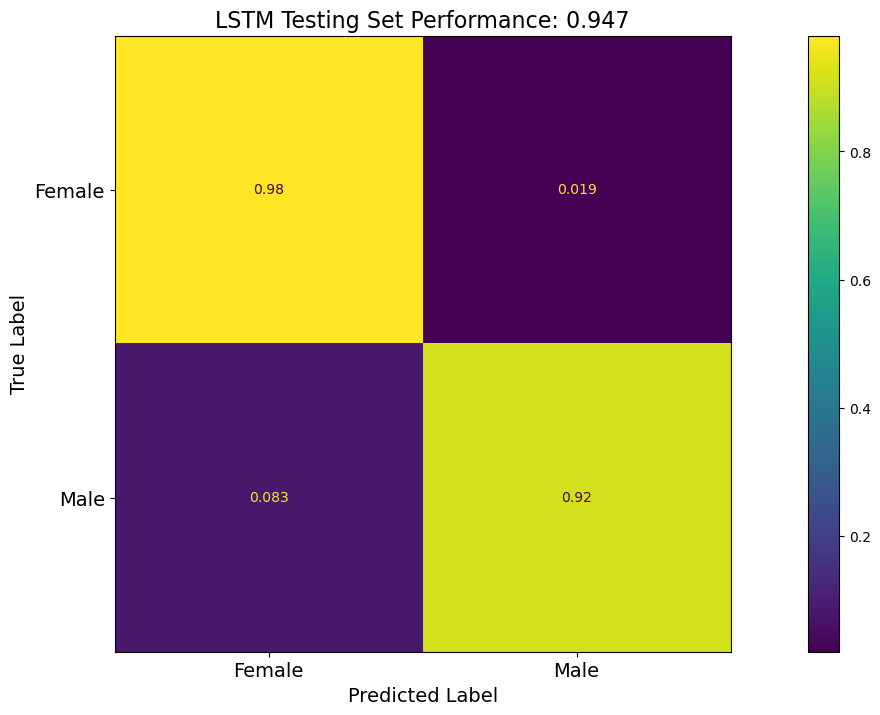

In [32]:
from sklearn.metrics import classification_report, f1_score
def eval_dnn(model, X_test, Y_test, path, threshold = 0.5):
    display_labels = ['Female', 'Male']
    fig = plt.figure(figsize=[20, 8])

    ax = fig.add_subplot(1, 1, 1)
    pred = model.predict(X_test, verbose=False) > threshold    
    conf = ConfusionMatrixDisplay.from_predictions(y_true = Y_test, y_pred = pred, normalize='true', ax=ax)
    conf.ax_.set_title('LSTM Testing Set Performance: ' + str(round(f1_score(Y_test, pred), 4)), fontsize=16);
    print(classification_report(Y_test, pred))
    conf.ax_.set_xticklabels(display_labels, fontsize=14)
    conf.ax_.set_yticklabels(display_labels, fontsize=14)
    conf.ax_.set_xlabel('Predicted Label', fontsize=14)
    conf.ax_.set_ylabel('True Label', fontsize=14)
    plt.savefig(path)

eval_dnn(model, x_test, y_test_encoded, path='../out/LSTM_test_Confusion_Matrix.jpg')

C:\Users\mpato\AppData\Local\Temp\ipykernel_41208\4266181971.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(display_labels, fontsize=14)
C:\Users\mpato\AppData\Local\Temp\ipykernel_41208\4266181971.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(display_labels, fontsize=14)


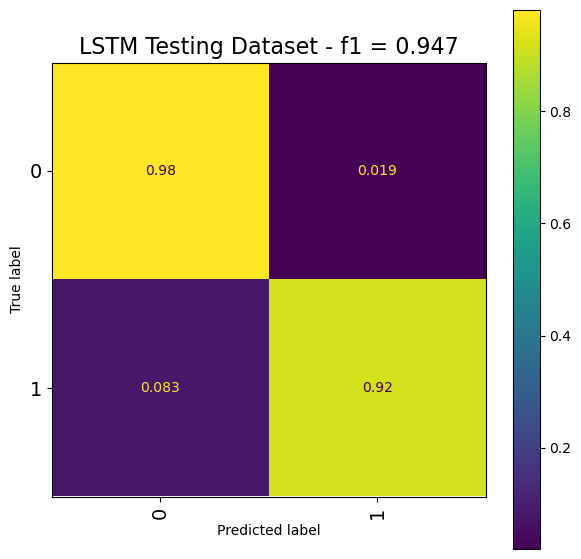

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
display_labels = ['Female', 'Male']
fig = plt.figure(figsize=[7, 7])
ax = fig.add_subplot(1, 1, 1)
ax.set_title(f"LSTM Testing Dataset - f1 = {round(f1_test,3)}", fontsize=16)
ax.set_xticklabels(display_labels, fontsize=14)
ax.set_yticklabels(display_labels, fontsize=14)
cm = confusion_matrix(y_test_encoded, test_indexes, normalize='true')
c = ConfusionMatrixDisplay(cm)
c.plot(ax = ax,  xticks_rotation = 'vertical')

plt.savefig('../out/LSTM_test_Confusion_Matrix.jpg')

In [22]:
import pickle
pickle.dump(history, open('../out/LSTM_1_layer_history.pkl', 'wb'))
pickle.dump(model, open('../out/LSTM_1_layer_Model_speaker.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://eb5b9263-e8db-48ec-80f2-6e7892465361/assets


INFO:tensorflow:Assets written to: ram://eb5b9263-e8db-48ec-80f2-6e7892465361/assets


INFO:tensorflow:Assets written to: ram://5b8fbb73-80bf-4916-a19c-9f56c8cb3b7d/assets


INFO:tensorflow:Assets written to: ram://5b8fbb73-80bf-4916-a19c-9f56c8cb3b7d/assets


c:\Users\mpato\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\mpato\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


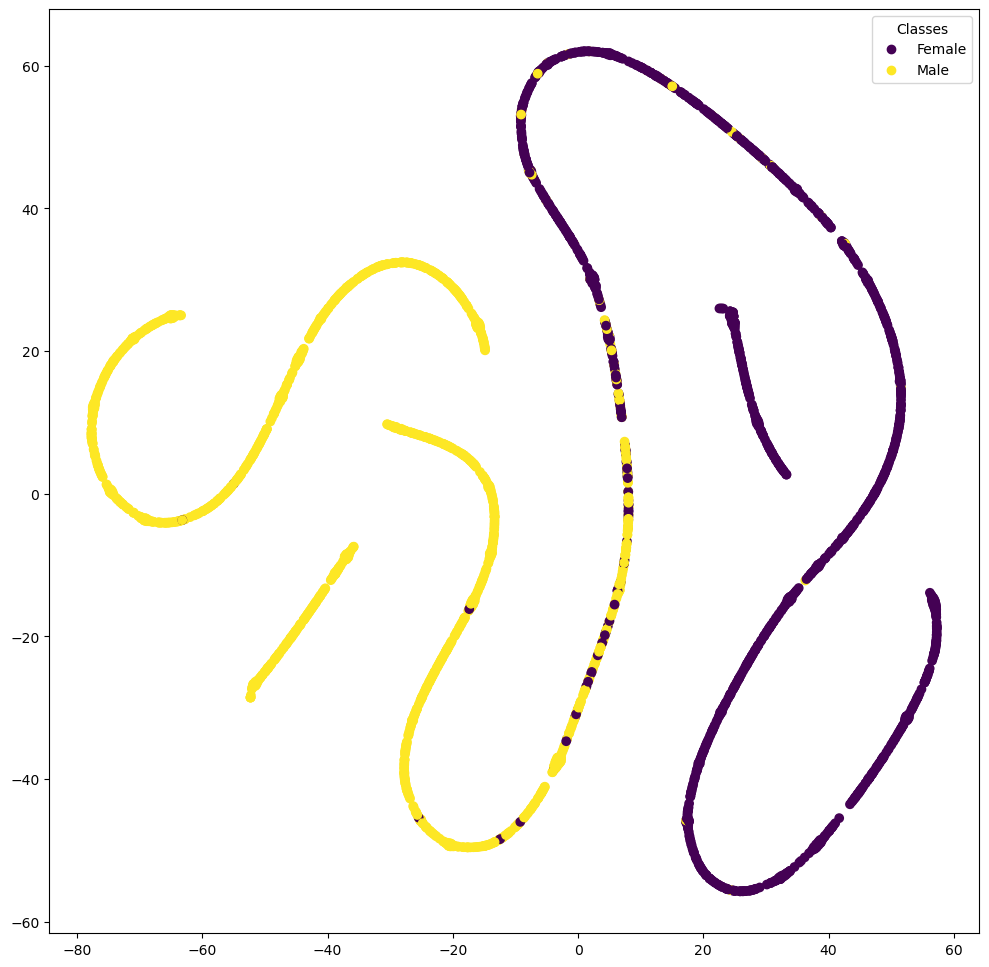

In [25]:
from sklearn.manifold import TSNE

test_embeddings = model.predict(x_test)
tsne_embeddings = TSNE(random_state=4).fit_transform(test_embeddings)
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
scatter = ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = y_test_encoded.flatten()); 

legend_labels = ['Female', 'Male']  # Replace with your class labels
ax.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Classes')

plt.savefig('../out/LSTM_1_layer_clusters.jpg')
plt.show()

In [24]:
# model = pickle.load(open('../out/LSTM_1_layer_Model_speaker.pkl', 'rb'))
# with open('../out/LSTM_1_layer_history.pkl', "rb") as file_pi:
#     history = pickle.load(file_pi)